In [1]:
import torch
from utils import models, nethook, activ, matching, helpers, dictionary, neuron_finding,cam
import os 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import torch.nn as nn
from torchvision.transforms import ToPILImage

/export/home/wuyueting/miniconda3/envs/mae-wyt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def draw_bar_chart(label_number,pkl_file,save_path,methods="abs"):
    print(f"Draw bar chart for label {label_number}...")
    f = open(pkl_file,"rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()

    weights = data[:, :, 0]
    activation =data[:,:,2]

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        weights = np.abs(weights)
    weight_accumulator = np.sum(weights, axis=0)
    average_gradients = weight_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_gradients.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Weight for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"weight_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/weight_plot.png")

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        activation = np.abs(activation)
    activation_accumulator = np.sum(activation, axis=0)
    average_activation = activation_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_activation.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Activation for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"activation_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/activation_plot.png")

In [3]:
label = "all"
folder_path = "/export/home/wuyueting/thyroid_data/BM/8_select5_nodule811_val_test/test/"
model_name = "thyroid_vit_small_5_nodule811"
target_layer="model.blocks[-1].mlp.act"
target_save_name = model_name+target_layer

<All keys matched successfully>


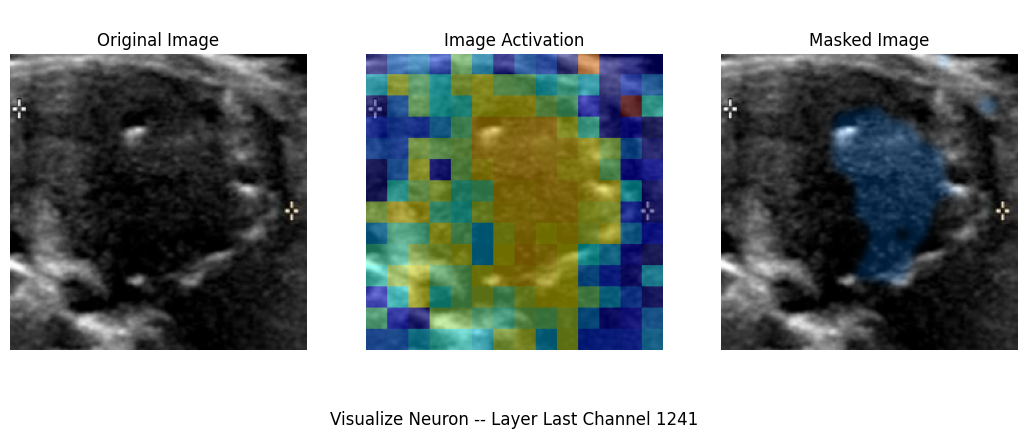

In [4]:
def visualize_neuron(neuron_id):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = "cpu"
    model,_ = models.load(model_name, device)
    model.eval()

    preprocess =transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.22,), (0.08,))
        ])
    
    image_path  = "/export/home/wuyueting/thyroid_data/BM/5_nodule811/test/1/b17161130084958.jpg"
    # image = Image.open(image_path).convert("RGB")
    # input_tensor = preprocess(image).unsqueeze(0)
    
    activ.get_one_neuron_image_activs(model,model_name,target_layer,reshape_transform,neuron_id,
                                                     image_path,visualize=True,masked=False) 

visualize_neuron(1241)